# Example: L23 human Extracellular current stimulation


In [1]:
#===========================================================================
# Import, Set up MPI Variables, Load Necessary Files
#===========================================================================
from mpi4py import MPI
import time
tic_0 = time.perf_counter() #script runtime calculation value
import os
from os.path import join
import sys
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from scipy import stats as st
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import pandas as pd

#MPI variables:
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()
GLOBALSEED = 1

# Create new RandomState for each RANK
SEED = GLOBALSEED*10000
np.random.seed(SEED + RANK)
local_state = np.random.RandomState(SEED + RANK)
halfnorm_rv = st.halfnorm
halfnorm_rv.random_state = local_state
uniform_rv = st.uniform
uniform_rv.random_state = local_state
#from net_params import *

#Mechanisms and files
print('Mechanisms found: ', os.path.isfile('mod/x86_64/special')) if RANK==0 else None
neuron.h('forall delete_section()')
neuron.load_mechanisms('mod/')
h.load_file('net_functions.hoc')

numprocs=1
Mechanisms found:  False
NEURON mechanisms not found in mod/.


1.0

In [2]:
#===========================================================================
# Simulation, Analysis, and Plotting Controls
#===========================================================================
TESTING = False # i.e.g generate 1 cell/pop, with 0.1 s runtime
no_connectivity = False

stimulate = True # Add a stimulus
MDD = False #decrease PN GtonicApic and MN2PN weight by 40%
DRUG = False

rec_LFP = False #record LFP from center of layer
rec_DIPOLES = False #record population - wide dipoles

run_circuit_functions = True
#===========================================================================
# Params
#===========================================================================
dt = 0.025 #for both cell and network
tstart = 0.
tstop = 4500.
celsius = 34.
v_init = -80. #for both cell and network

##################################################################################

OUTPUTPATH = 'Circuit_output'

networkParams = {
        'dt' : dt,
        'tstart': tstart,
        'tstop' : tstop,
        'v_init' : v_init,
        'celsius' : celsius,
        'OUTPUTPATH' : OUTPUTPATH,
        'verbose': False}

#              L2/3   L4     L5
PYRmaxApics = [550   ,1550   ,1900]
uppers =      [-250  ,-1200 ,-1600]
lowers =      [-1200 ,-1580 ,-2300]

depths = []
rangedepths = []
minSynLocs = []
syn_pos = []
pop_args = {}

for i in range (3):
    depths.append((lowers[i]-uppers[i])/2-PYRmaxApics[i])
    rangedepths.append(abs(lowers[i]-uppers[i])/2)
    minSynLocs.append((lowers[i]-uppers[i])/2*3-PYRmaxApics[i])

    syn_pos.append({'section' : ['apic', 'dend'],
                    'fun' : [uniform_rv, halfnorm_rv],
                    'funargs' : [{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])},{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])}],
                    'funweights' : [1, 1.]})
    syn_pos.append({'section' : ['apic'],
                    'fun' : [uniform_rv],
                    'funargs' : [{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])}],
                    'funweights' : [1.]})
    syn_pos.append({'section' : ['dend'],
                    'fun' : [uniform_rv],
                    'funargs' : [{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])}],
                    'funweights' : [1.]})
    syn_pos.append({'section' : ['dend'],
                   'fun' : [halfnorm_rv],
                   'funargs' : [{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])}],
                   'funweights' : [1.]})
    names = ['HL2','HL4','HL5']
    pop_args[names[i]]={'radius':250,
                        'loc':depths[i],
                        'scale':rangedepths[i]*4,
                        'cap':rangedepths[i]}

# class RecExtElectrode parameters:
L23_size = abs(uppers[1] - lowers[1])
e1 = 5 #-725


In [3]:
###################### Load and organize Excel file ################################
circuit_params = {}

#Import Excel file
circuit_params = pd.read_excel('Circuit_param.xls', sheet_name = None, index_col = 0)

#Get cell names and import biophys
cell_names = [i for i in circuit_params['conn_probs'].axes[0]]
for name in cell_names:
    h.load_file('models/biophys_'+name+'.hoc')
    
network = Network(**networkParams)

In [4]:

#===========================================================================
# Functions
#===========================================================================
def generateSubPop(popsize,mname,popargs,Gou,Gtonic,GtonicApic):
    print('Initiating ' + mname + ' population...') if RANK==0 else None
    morphpath = 'morphologies/' + mname + '.swc'
    templatepath = 'models/NeuronTemplate.hoc'
    templatename = 'NeuronTemplate'
    pt3d = True
    cellParams = {
            'morphology': morphpath,
            'templatefile': templatepath,
            'templatename': templatename,
            'templateargs': morphpath,
            'v_init': v_init, #initial membrane potential, d=-65
            'passive': False,#initialize passive mechs, d=T, should be overwritten by biophys
            'dt': dt,
            'tstart': 0.,
            'tstop': tstop,#defaults to 100
            'nsegs_method': None,
            'pt3d': pt3d,#use pt3d-info of the cell geometries switch, d=F
            'delete_sections': False,
            'verbose': False}#verbose output switch, for some reason doens't work, figure out why}

    
    rotation = {'x':circuit_params['SING_CELL_PARAM'].at['rotate_x', mname],'y':circuit_params['SING_CELL_PARAM'].at['rotate_y', mname]}

    popParams = {
            'CWD': None,
            'CELLPATH': None,
            'Cell' : LFPy.NetworkCell, #play around with this, maybe put popargs into here
            'POP_SIZE': int(popsize),
            'name': mname,
            'cell_args' : {**cellParams},
            'pop_args' : popargs,
            'rotation_args' : rotation}

    network.create_population(**popParams)

    # Add biophys, OU processes, & tonic inhibition to cells
    for cellind in range(0,len(network.populations[mname].cells)):
        rseed = int(local_state.uniform()*SEED)
        biophys = 'h.biophys_' + mname + '(network.populations[\'' + mname + '\'].cells[' + str(cellind) + '].template)'
        exec(biophys)
        h.createArtificialSyn(rseed,network.populations[mname].cells[cellind].template,Gou)
        h.addTonicInhibition(network.populations[mname].cells[cellind].template,Gtonic,GtonicApic)


In [5]:
# Generate Populations
tic = time.perf_counter()

for cell_name in cell_names:
    generateSubPop(circuit_params['SING_CELL_PARAM'].at['cell_num',cell_name],
                       cell_name,pop_args[cell_name[:3]],
                       circuit_params['SING_CELL_PARAM'].at['GOU',cell_name],
                       circuit_params['SING_CELL_PARAM'].at['norm_tonic',cell_name],               
                       circuit_params['SING_CELL_PARAM'].at['apic_tonic',cell_name])

Initiating HL23PYR population...
Initiating HL23SST population...
Initiating HL23PV population...
Initiating HL23VIP population...


In [6]:
simargs = {'rec_imem': False,
           'rec_vmem': False,
           'rec_ipas': False,
           'rec_icap': False,
           'rec_isyn': False,
           'rec_vmemsyn': False,
           'rec_istim': False,
           'rec_current_dipole_moment':False,
           'rec_pop_contributions': False,
           'rec_variables': [],
           'to_memory': True,
           'to_file': False,
           'file_name':'OUTPUT.h5',
           'dotprodcoeffs': None}


In [7]:

tic = time.perf_counter()

print('Simulating, recording SPIKES ... ') if RANK==0 else None
SPIKES = network.simulate(**simargs)

print('Simulation took ', str((time.perf_counter() - tic_0)/60)[:5], 'minutes') if RANK==0 else None

tic = time.perf_counter()
print('Saving simulation output ...')
np.save(os.path.join(OUTPUTPATH,'SPIKES_Seed'+str(GLOBALSEED)+'.npy'), SPIKES)

Simulating, recording SPIKES ... 
Simulation took  1.195 minutes
Saving simulation output ...


In [8]:
SPIKES

{'times': [[array([  78.35      ,  861.5       , 1201.725     , 1914.4       ,
          2862.39999999])],
  [array([], dtype=float64)],
  [array([ 774.6       ,  801.425     ,  833.6       , 1274.3       ,
          4110.49999998, 4191.49999997])],
  [array([], dtype=float64)]],
 'gids': [[0], [1], [2], [3]]}

# Example: Extracellular current stimulation


In [1]:
%matplotlib inline
import sys
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron
import pandas as pd

###  See Fetch Hallermann et al. (2012) model files
We use this cell model, because it has a relatively sophisticated axon model, with myelinated and unmyelinated parts.

In [2]:
#===========================================================================
# Params
#===========================================================================
# dt = 0.025 #for both cell and network
tstart = 0.
# tstop = 4500.
celsius = 34.
v_init = -80. #for both cell and network
tstop = 30
dt = 2**-5
###################### Load and organize Excel file ################################
circuit_params = {}

#Import Excel file
circuit_params = pd.read_excel('Circuit_param.xls', sheet_name = None, index_col = 0)

#Get cell names and import biophys
cell_names = [i for i in circuit_params['conn_probs'].axes[0]]
for name in cell_names:
    neuron.h.load_file('models/biophys_'+name+'.hoc')

    
cell_name = cell_names[0]

mname = cell_name
print('Initiating ' + mname + ' population...')
morphpath = 'morphologies/' + mname + '.swc'
templatepath = 'models/NeuronTemplate.hoc'
templatename = 'NeuronTemplate'
pt3d = True

rotation = {'x':circuit_params['SING_CELL_PARAM'].at['rotate_x', mname],'y':circuit_params['SING_CELL_PARAM'].at['rotate_y', mname]}

Initiating HL23PYR population...


In [3]:
cellParameters = {
    'morphology': morphpath,
    'templatefile' :  templatepath,
    'templatename' :  templatename,
    'templateargs' :  morphpath,
    'v_init': v_init,  # initial membrane potential
    'passive': False,  # do not add default passive mechs
    'nsegs_method': None,
    'dt': dt,  # [ms] dt's should be in powers of 2 for both,
    'tstart': -100,  # start time of simulation, recorders start at t=0
    'tstop': tstop,
    "extracellular": True,
    "pt3d": True,
}
cell = LFPy.TemplateCell(**cellParameters)

In [4]:
rotation

{'x': 1.57, 'y': 2.62}

In [5]:
# cell.set_rotation(rotation)
cell.set_rotation(x=1.57, y=2.62, z=0)


In [6]:
len(cell.allsecnames)

244

### Function to calculate external potential from point current source

In [7]:
def make_extracellular_stimuli(dbs_params, cell):
    """ Function to calculate and apply external potential """
    x0, y0, z0 = dbs_params['position']
    sigma = 0.3
    ext_field = np.vectorize(lambda x,y,z: 1 / (4 * np.pi* sigma * np.sqrt(
        (x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2)))
    
    ### MAKING THE EXTERNAL FIELD
    n_tsteps = int(cell.tstop / cell.dt + 1)
    t = np.arange(n_tsteps) * cell.dt
    pulse = np.zeros(n_tsteps)
    start_time = dbs_params['start_time']
    end_time = dbs_params['end_time']
    start_idx = np.argmin(np.abs(t - start_time))
    end_idx = np.argmin(np.abs(t - end_time))
    pulse[start_idx:end_idx] = dbs_params['amp'] * 1000.

    v_cell_ext = np.zeros((cell.totnsegs, n_tsteps))
    v_cell_ext[:, :] = ext_field(cell.x.mean(axis=-1), cell.y.mean(axis=-1), cell.z.mean(axis=-1)
                                ).reshape(cell.totnsegs, 1) * pulse.reshape(1, n_tsteps)
    
    print()
    
    cell.insert_v_ext(v_cell_ext, t)
    return ext_field, pulse

### Defining plotting functions

In [8]:
def plot_cell_secs(cell, ax_m):
    """ 
    Plotting function to plot cell morphology with 
    different sections in different colors
    """
    plot_idxs = [cell.somaidx[0],
                 cell.get_closest_idx(z=700, section='apic'),
                 cell.get_closest_idx(z=-850, section="axon"),
                 cell.get_closest_idx(z=0, section="axon"),
                 cell.get_closest_idx(z=1000, section="axon")
                 ]
    idx_clr = {idx: ['cyan', 'olive', 'b', 'darkviolet','k'][num]
               for num, idx in enumerate(plot_idxs)}
    
    possible_names = ["Myelin", "axon", "Unmyelin", "Node", "node", "my",
                      "hilloc",
                      "hill", "apic", "dend", "soma"]

    # We want sensible section names for the labels
    sec_name_mapping = {
        'soma': 'soma',
        'axon': "unmyelinated axon",
        'dend': "basal dendrite",
        'apic': "apical dendrite",
        'node': "node of Rannvier",
        'my': 'myelinated axon',
        }
    sec_clrs = {"Myelin": 'olive',
            "dend": 'yellow',
            "soma": 'k',
            'apic': 'white',
            "axon": 'purple',
            "node": 'orange',
            "my": 'g',
            "Unmyelin": 'salmon',
            "Node": 'orange',
            "hilloc": 'lightblue',
            "hill": 'pink',}

    used_sec_clrs = []
    used_sec_names = []
    
    
    for idx in range(cell.totnsegs):
        sec_name = cell.get_idx_name(idx)[1]
        for name_ in possible_names:
            if name_ in sec_name:
                c = sec_clrs[name_]
                if not sec_name_mapping[name_] in used_sec_names:
                    used_sec_clrs.append(c)
                    used_sec_names.append(sec_name_mapping[name_])
        if idx == 0:
            # Plot soma as dot
            ax_m.plot(cell.x[idx].mean(), cell.z[idx].mean(), 'o',
                  c=c, clip_on=True, ms=12)            
        else:
            ax_m.plot(cell.x[idx], cell.z[idx], '-',
                  c=c, clip_on=True, lw=1)

    
    [ax_m.plot(cell.x[idx].mean(), cell.z[idx].mean(), 'o',
               c=idx_clr[idx], ms=6, zorder=5) for idx in plot_idxs]
    return plot_idxs, idx_clr, used_sec_names, used_sec_clrs



def plotting_function(dbs_params, cell, ext_field, pulse):
    """
    Plotting function to plot cell and membrane potential.
    """
    x0, y0, z0 = dbs_params['position']
    amp = dbs_params['amp'] * 1000.
    
    ### PLOTTING THE RESULTS

    # Plotting the morphology
    plt.close('all')
    fig = plt.figure(figsize=(16,9))
    fig.subplots_adjust(hspace=0.5, bottom=0.15)
    
    ax_m = fig.add_subplot(121, aspect=1, xlabel='x [µm]', ylabel='z [µm]', 
                xticks=[-200, 0, 200], ylim=[-200, 550], xlim=[-200, 200] )
    ax1 = fig.add_subplot(222, title='membrane potential', xlabel='Time [ms]', xlim=[10, 30], 
                          ylabel='mV', ylim=[-110, 60])
    
    ax2 = plt.subplot(224, ylim=[-2*np.max(np.abs(pulse / 1000)), 
                                 2*np.max(np.abs(pulse / 1000))], 
                      ylabel='µA', title='injected current', xlabel='Time [ms]', xlim=[10, 30])    
    
    # Plotting the extracellular potential produced by external stimuli
    v_field_ext = np.zeros((50, 200))
    xf = np.linspace(np.min(cell.x[:, 1]), np.max(cell.x[:, 1]), 50)
    zf = np.linspace(np.min(cell.z[:, 1]), np.max(cell.z[:, 1]), 200)
    for xidx, x in enumerate(xf):
       for zidx, z in enumerate(zf):
           v_field_ext[xidx, zidx] = ext_field(x, 0, z) * amp

    img = ax_m.imshow(v_field_ext.T, extent=[np.min(cell.x[:, 1]), np.max(cell.x[:, 1]), 
                                     np.min(cell.z[:, 1]), np.max(cell.z[:, 1])], 
              origin='lower', interpolation='nearest', cmap=plt.cm.bwr_r, vmin=-50, vmax=50)
    plt.colorbar(img, ax=ax_m, label='mV')
    
    cell_plot_idxs, cell_plot_colors, used_sec_names, used_sec_clrs = plot_cell_secs(cell, ax_m)   

    l, = ax_m.plot(x0, z0, 'y*', ms=12)

    # Add morphology legend markers
    lines = [l]
    line_names = ["current stimuli"]    
    for sec_name, sec_clr in zip(used_sec_names, used_sec_clrs):
        l_, = ax_m.plot([], [], c=sec_clr)
        lines.append(l_)
        line_names.append(sec_name)
    fig.legend(lines, line_names, frameon=False, ncol=3, loc=(0.1, 0.02))

    # Plotting the membrane potentials
    lines = []
    line_names = []
    for idx in cell_plot_idxs:
        l, = ax1.plot(cell.tvec, cell.vmem[idx, :], c=cell_plot_colors[idx], lw=2)
        lines.append(l)
        comp_loc = int(cell.x[idx].mean()), int(cell.y[idx].mean()), int(cell.z[idx].mean())
        line_names.append(f'{comp_loc} µm')
    ax1.legend(lines, line_names, frameon=False, loc="upper right")
    
    # Plotting the input currents
    ax2.plot(cell.tvec, pulse / 1000, c='k')


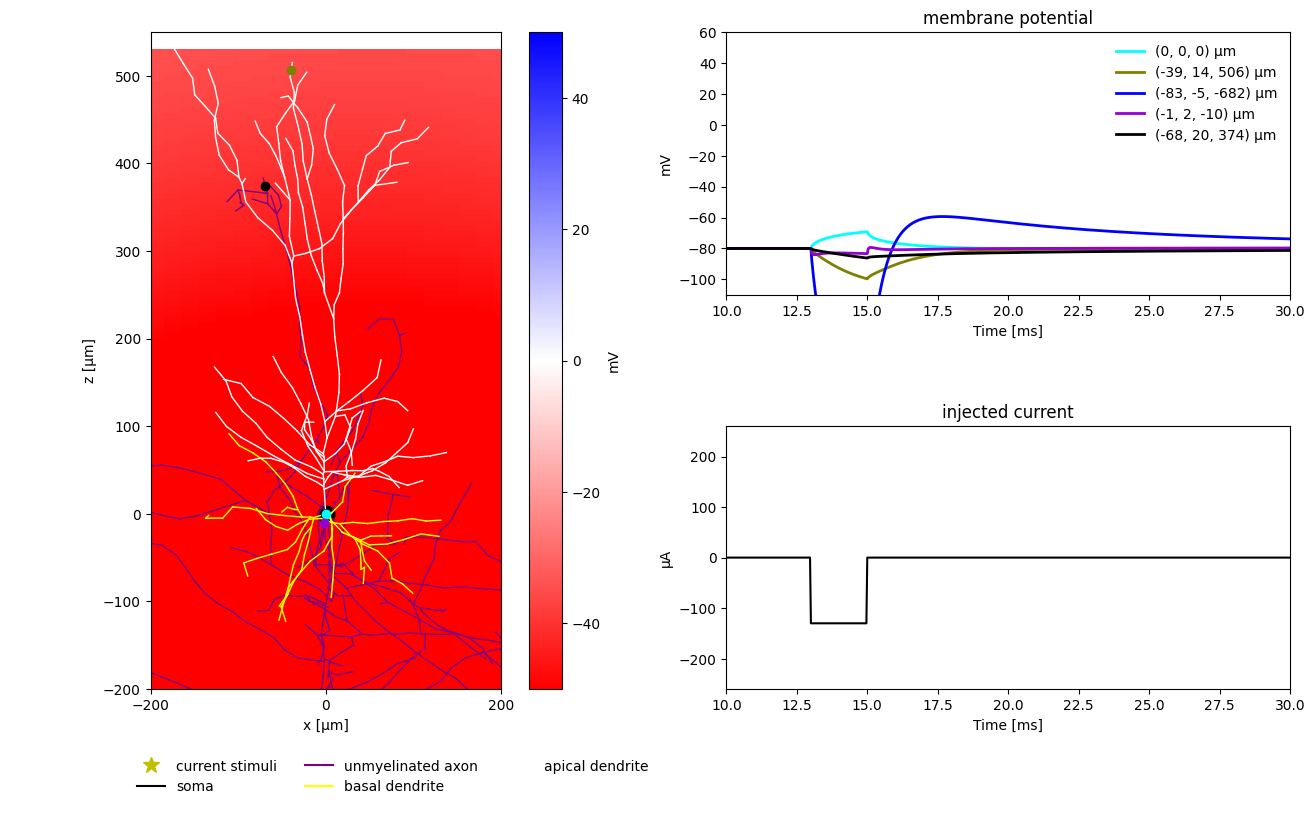

In [9]:
tstop = 30
dt = 2**-5

# delete old sections from NEURON namespace
# neuron.h("forall delete_section()")

# cell = return_hallermann_cell(tstop, dt, )

# The parameters of the extracellular point current source 
dbs_params = {'position': [50, 0,  -450],  # x, y, z in µm
              'amp': -130., # µA,
              'start_time': 13.,  # ms
              'end_time': 15.,  # ms
              }

ext_field, pulse = make_extracellular_stimuli(dbs_params, cell)

cell.simulate(rec_vmem=True)

plotting_function(dbs_params, cell, ext_field, pulse)

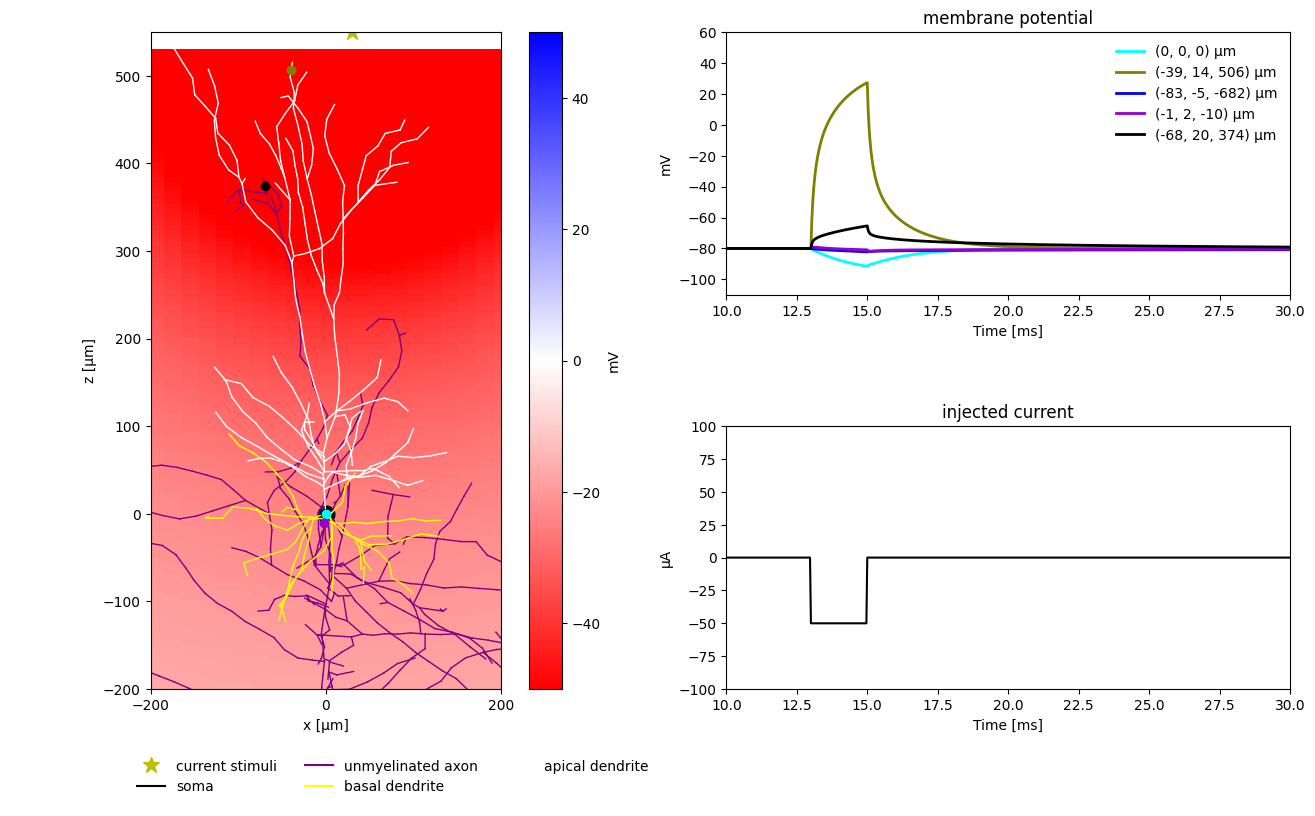

In [10]:
tstop = 30
dt = 2**-5

# delete old sections from NEURON namespace
# neuron.h("forall delete_section()")

# cell = return_hallermann_cell(tstop, dt, )

# The parameters of the extracellular point current source 
dbs_params = {'position': [30, 0,  550],  # x, y, z in µm
              'amp': -50., # µA,
              'start_time': 13.,  # ms
              'end_time': 15.,  # ms
              }

ext_field, pulse = make_extracellular_stimuli(dbs_params, cell)

cell.simulate(rec_vmem=True)

plotting_function(dbs_params, cell, ext_field, pulse)

In [ ]:
# from neuron import h, gui